# 🧱 DCGAN - 블록 데이터

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/rickiepark/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/04_gan/01_dcgan/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 utils.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
    !mkdir -p notebooks
    !mv utils.py notebooks

--2024-04-08 02:31:01--  https://raw.githubusercontent.com/rickiepark/Generative_Deep_Learning_2nd_Edition/main/notebooks/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 771 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     771  --.-KB/s    in 0s      

2024-04-08 02:31:02 (50.7 MB/s) - ‘utils.py’ saved [771/771]



이 노트북에서는 레고 블록 데이터셋에서 DCGAN을 훈련합니다.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

from notebooks.utils import display, sample_batch

## 0. 파라미터 <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 100 # 훈련이 오래 걸려 에포크 횟수를 300에서 100으로 줄입니다.
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

## 1. 데이터 준비 <a name="prepare"></a>

In [4]:
# 코랩일 경우 노트북에서 celeba 데이터셋을 받습니다.
if 'google.colab' in sys.modules:
    # # 캐글-->Setttings-->API-->Create New Token에서
    # # kaggle.json 파일을 만들어 코랩에 업로드하세요.
    # from google.colab import files
    # files.upload()
    # !mkdir ~/.kaggle
    # !cp kaggle.json ~/.kaggle/
    # !chmod 600 ~/.kaggle/kaggle.json
    # # celeba 데이터셋을 다운로드하고 압축을 해제합니다.
    # !kaggle datasets download -d joosthazelzet/lego-brick-images
    #
    # 캐글에서 다운로드가 안 될 경우 역자의 드라이브에서 다운로드할 수 있습니다.
    import gdown
    gdown.download(id='1qd50QDZtr_NYFiFVdp0sIvGDwTT3mMEQ')
    !unzip -q lego-brick-images.zip
    # output 디렉토리를 만듭니다.
    !mkdir output

Downloading...
From (original): https://drive.google.com/uc?id=1qd50QDZtr_NYFiFVdp0sIvGDwTT3mMEQ
From (redirected): https://drive.google.com/uc?id=1qd50QDZtr_NYFiFVdp0sIvGDwTT3mMEQ&confirm=t&uuid=4a993522-ae4a-4fe1-83f2-e0f43183560d
To: /content/lego-brick-images.zip
100%|██████████| 1.07G/1.07G [00:10<00:00, 100MB/s]


In [5]:
train_data = utils.image_dataset_from_directory(
    "./dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 40000 files belonging to 1 classes.


In [6]:
def preprocess(img):
    """
    이미지 정규화 및 크기 변경
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

In [7]:
train_sample = sample_batch(train)

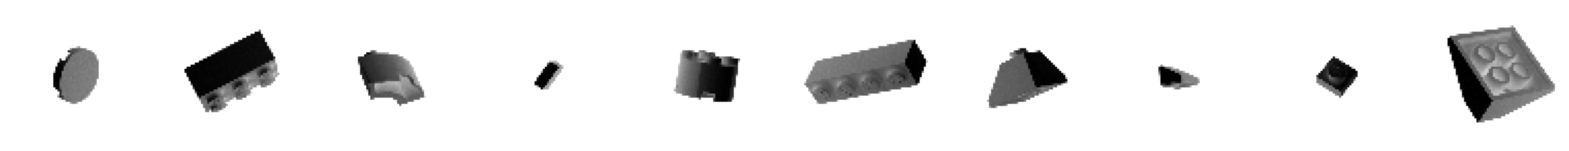

In [8]:
display(train_sample)

## 2. GAN 구축 <a name="build"></a>

In [9]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(
    discriminator_input
)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    512, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="sigmoid",
)(x)
discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization (Batch  (None, 16, 16, 128)       512       
 Normalization)                                                  
                                                             

In [10]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 512)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_3 (Bat  (None, 4, 4, 512)         2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 256)         2097

In [11]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # 잠재 공간에서 랜덤 포인트 샘플링
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # 가짜 이미지로 판별자 훈련하기
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # 메트릭 업데이트
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [12]:
# DCGAN 생성
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

In [13]:
if LOAD_MODEL:
    dcgan.load_weights("./checkpoint/checkpoint.ckpt")

## 3. GAN 훈련 <a name="train"></a>

In [14]:
dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [15]:
# 모델 저장 체크포인트 만들기
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0: # 출력 횟수를 줄이기 위해
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = generated_images * 127.5 + 127.5
            generated_images = generated_images.numpy()
            display(
                generated_images,
                save_to="./output/generated_img_%03d.png" % (epoch),
            )

Epoch 1/100
313/313 [==============================] - ETA: 0s - d_loss: 0.3086 - d_real_acc: 0.8225 - d_fake_acc: 0.8332 - d_acc: 0.8278 - g_loss: 3.5000 - g_acc: 0.1669
Saved to ./output/generated_img_000.png


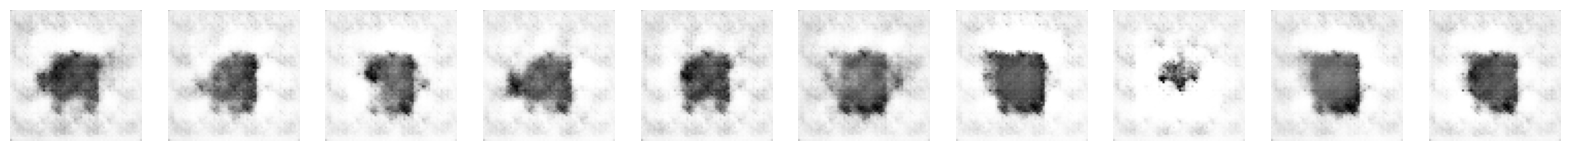

313/313 [==============================] - 80s 213ms/step - d_loss: 0.3086 - d_real_acc: 0.8225 - d_fake_acc: 0.8332 - d_acc: 0.8278 - g_loss: 3.5000 - g_acc: 0.1669
Epoch 2/100
313/313 [==============================] - 66s 205ms/step - d_loss: 0.0721 - d_real_acc: 0.8899 - d_fake_acc: 0.9018 - d_acc: 0.8959 - g_loss: 4.5377 - g_acc: 0.0981
Epoch 3/100
313/313 [==============================] - 69s 213ms/step - d_loss: 0.1451 - d_real_acc: 0.8685 - d_fake_acc: 0.8716 - d_acc: 0.8701 - g_loss: 4.3242 - g_acc: 0.1284
Epoch 4/100
313/313 [==============================] - 66s 207ms/step - d_loss: 0.1956 - d_real_acc: 0.8612 - d_fake_acc: 0.8605 - d_acc: 0.8608 - g_loss: 3.7292 - g_acc: 0.1395
Epoch 5/100
313/313 [==============================] - 66s 206ms/step - d_loss: 0.1920 - d_real_acc: 0.8622 - d_fake_acc: 0.8611 - d_acc: 0.8616 - g_loss: 3.5391 - g_acc: 0.1390
Epoch 6/100
313/313 [==============================] - 68s 213ms/step - d_loss: 0.1402 - d_real_acc: 0.8807 - d_fake_acc: 

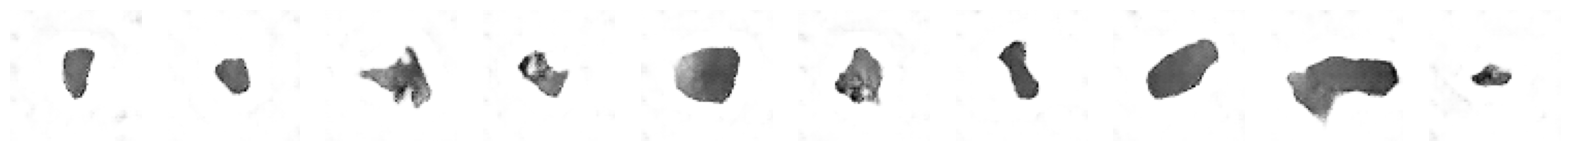

313/313 [==============================] - 72s 226ms/step - d_loss: 0.0696 - d_real_acc: 0.8996 - d_fake_acc: 0.8982 - d_acc: 0.8989 - g_loss: 4.5236 - g_acc: 0.1018
Epoch 12/100
313/313 [==============================] - 71s 223ms/step - d_loss: 0.0621 - d_real_acc: 0.8997 - d_fake_acc: 0.8989 - d_acc: 0.8993 - g_loss: 4.5959 - g_acc: 0.1011
Epoch 13/100
313/313 [==============================] - 73s 229ms/step - d_loss: 0.0368 - d_real_acc: 0.9115 - d_fake_acc: 0.9132 - d_acc: 0.9123 - g_loss: 4.6163 - g_acc: 0.0869
Epoch 14/100
313/313 [==============================] - 72s 224ms/step - d_loss: 0.0175 - d_real_acc: 0.9167 - d_fake_acc: 0.9187 - d_acc: 0.9177 - g_loss: 5.1575 - g_acc: 0.0813
Epoch 15/100
313/313 [==============================] - 72s 221ms/step - d_loss: 0.0346 - d_real_acc: 0.9186 - d_fake_acc: 0.9182 - d_acc: 0.9184 - g_loss: 4.9611 - g_acc: 0.0818
Epoch 16/100
313/313 [==============================] - 71s 224ms/step - d_loss: 0.0143 - d_real_acc: 0.9169 - d_fake_

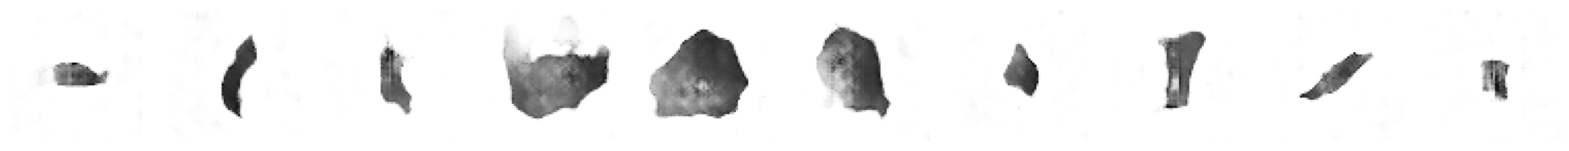

313/313 [==============================] - 72s 226ms/step - d_loss: -0.0453 - d_real_acc: 0.9289 - d_fake_acc: 0.9288 - d_acc: 0.9289 - g_loss: 5.9258 - g_acc: 0.0712
Epoch 22/100
313/313 [==============================] - 72s 224ms/step - d_loss: -0.0839 - d_real_acc: 0.9380 - d_fake_acc: 0.9378 - d_acc: 0.9379 - g_loss: 6.1671 - g_acc: 0.0622
Epoch 23/100
313/313 [==============================] - 71s 223ms/step - d_loss: -0.0416 - d_real_acc: 0.9273 - d_fake_acc: 0.9301 - d_acc: 0.9287 - g_loss: 6.5701 - g_acc: 0.0698
Epoch 24/100
313/313 [==============================] - 72s 223ms/step - d_loss: -0.0069 - d_real_acc: 0.9215 - d_fake_acc: 0.9190 - d_acc: 0.9202 - g_loss: 5.9352 - g_acc: 0.0810
Epoch 25/100
313/313 [==============================] - 70s 220ms/step - d_loss: -0.0627 - d_real_acc: 0.9326 - d_fake_acc: 0.9321 - d_acc: 0.9323 - g_loss: 6.0323 - g_acc: 0.0679
Epoch 26/100
313/313 [==============================] - 70s 216ms/step - d_loss: 7.0816 - d_real_acc: 0.0774 - d_

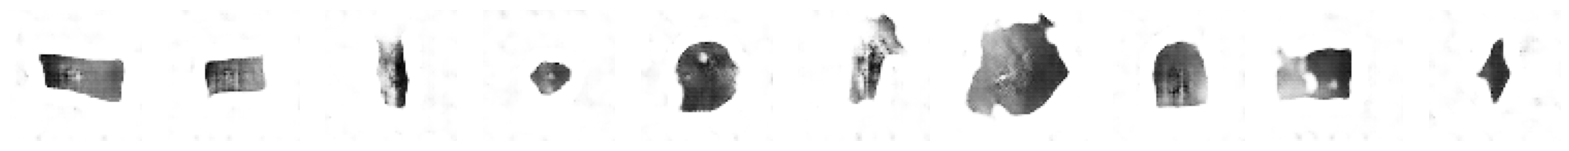

313/313 [==============================] - 73s 226ms/step - d_loss: 7.7110 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 32/100
313/313 [==============================] - 72s 224ms/step - d_loss: 7.7126 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 33/100
313/313 [==============================] - 73s 226ms/step - d_loss: 7.7148 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 34/100
313/313 [==============================] - 73s 228ms/step - d_loss: 7.7128 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 35/100
313/313 [==============================] - 72s 221ms/step - d_loss: 7.7133 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 36/100
313/313 [==============================] - 73s 229ms/step - 

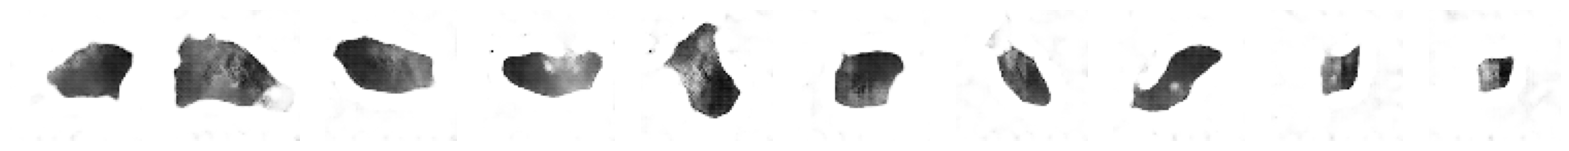

313/313 [==============================] - 74s 231ms/step - d_loss: 7.7108 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 42/100
313/313 [==============================] - 73s 225ms/step - d_loss: 7.7095 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 43/100
313/313 [==============================] - 73s 229ms/step - d_loss: 7.7111 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 44/100
313/313 [==============================] - 73s 230ms/step - d_loss: 7.7128 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 45/100
313/313 [==============================] - 71s 221ms/step - d_loss: 7.7129 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 46/100
313/313 [==============================] - 72s 221ms/step - 

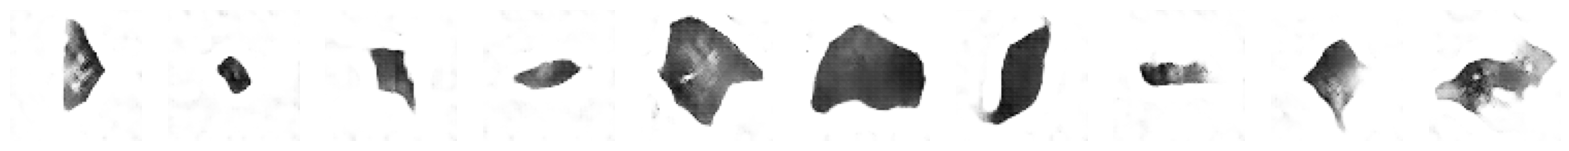

313/313 [==============================] - 73s 228ms/step - d_loss: 7.7127 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 52/100
313/313 [==============================] - 70s 220ms/step - d_loss: 5.0947 - d_real_acc: 0.2986 - d_fake_acc: 0.7952 - d_acc: 0.5469 - g_loss: 9.5118 - g_acc: 0.2048
Epoch 53/100
313/313 [==============================] - 73s 225ms/step - d_loss: 0.8586 - d_real_acc: 0.5969 - d_fake_acc: 0.6062 - d_acc: 0.6016 - g_loss: 1.4498 - g_acc: 0.3938
Epoch 54/100
313/313 [==============================] - 73s 228ms/step - d_loss: 0.5900 - d_real_acc: 0.7089 - d_fake_acc: 0.7139 - d_acc: 0.7114 - g_loss: 2.0681 - g_acc: 0.2860
Epoch 55/100
313/313 [==============================] - 70s 218ms/step - d_loss: 0.0908 - d_real_acc: 0.8913 - d_fake_acc: 0.8933 - d_acc: 0.8923 - g_loss: 4.3853 - g_acc: 0.1067
Epoch 56/100
313/313 [==============================] - 72s 224ms/step - d_loss: -0.0476 - d_real_acc: 0.9272

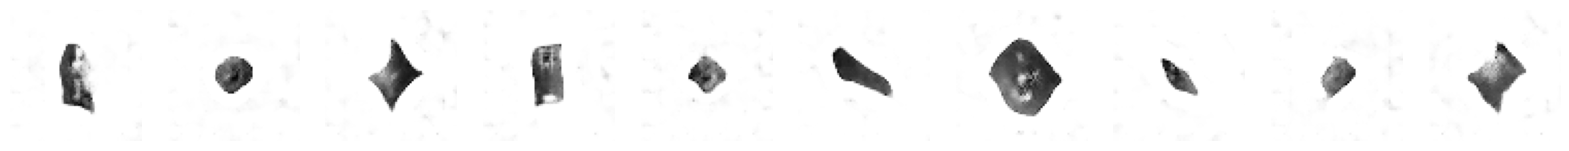

313/313 [==============================] - 73s 226ms/step - d_loss: -0.0786 - d_real_acc: 0.9320 - d_fake_acc: 0.9319 - d_acc: 0.9319 - g_loss: 6.6428 - g_acc: 0.0681
Epoch 62/100
313/313 [==============================] - 72s 226ms/step - d_loss: -0.1714 - d_real_acc: 0.9456 - d_fake_acc: 0.9460 - d_acc: 0.9458 - g_loss: 7.0604 - g_acc: 0.0540
Epoch 63/100
313/313 [==============================] - 71s 221ms/step - d_loss: -0.0645 - d_real_acc: 0.9246 - d_fake_acc: 0.9244 - d_acc: 0.9245 - g_loss: 6.8537 - g_acc: 0.0756
Epoch 64/100
313/313 [==============================] - 73s 228ms/step - d_loss: -0.1546 - d_real_acc: 0.9380 - d_fake_acc: 0.9394 - d_acc: 0.9387 - g_loss: 7.1697 - g_acc: 0.0606
Epoch 65/100
313/313 [==============================] - 71s 222ms/step - d_loss: -0.2212 - d_real_acc: 0.9575 - d_fake_acc: 0.9560 - d_acc: 0.9568 - g_loss: 7.8893 - g_acc: 0.0440
Epoch 66/100
313/313 [==============================] - 73s 225ms/step - d_loss: -0.1772 - d_real_acc: 0.9415 - d

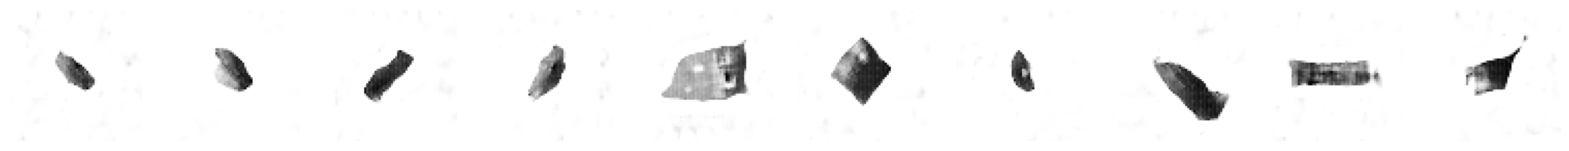

313/313 [==============================] - 73s 230ms/step - d_loss: -0.3077 - d_real_acc: 0.9628 - d_fake_acc: 0.9639 - d_acc: 0.9633 - g_loss: 9.2646 - g_acc: 0.0361
Epoch 72/100
313/313 [==============================] - 71s 222ms/step - d_loss: -0.3468 - d_real_acc: 0.9606 - d_fake_acc: 0.9612 - d_acc: 0.9609 - g_loss: 10.1814 - g_acc: 0.0388
Epoch 73/100
313/313 [==============================] - 73s 225ms/step - d_loss: -0.3651 - d_real_acc: 0.9660 - d_fake_acc: 0.9665 - d_acc: 0.9662 - g_loss: 10.0153 - g_acc: 0.0335
Epoch 74/100
313/313 [==============================] - 72s 225ms/step - d_loss: -0.6264 - d_real_acc: 0.9899 - d_fake_acc: 0.9892 - d_acc: 0.9895 - g_loss: 13.4471 - g_acc: 0.0108
Epoch 75/100
313/313 [==============================] - 73s 227ms/step - d_loss: -0.2358 - d_real_acc: 0.9485 - d_fake_acc: 0.9539 - d_acc: 0.9512 - g_loss: 10.0544 - g_acc: 0.0461
Epoch 76/100
313/313 [==============================] - 73s 228ms/step - d_loss: -0.5621 - d_real_acc: 0.9825

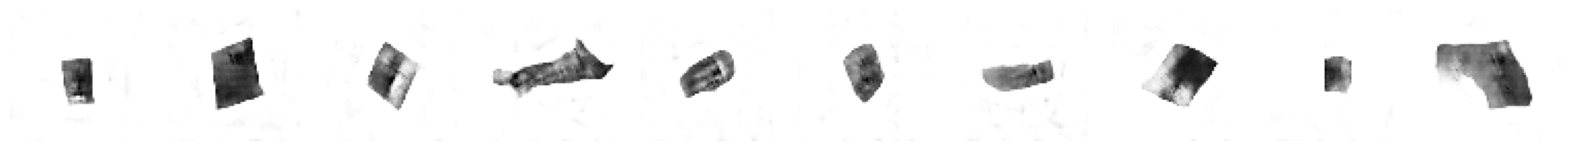

313/313 [==============================] - 73s 228ms/step - d_loss: -0.2571 - d_real_acc: 0.9462 - d_fake_acc: 0.9506 - d_acc: 0.9484 - g_loss: 9.5712 - g_acc: 0.0494
Epoch 82/100
313/313 [==============================] - 70s 221ms/step - d_loss: -0.2059 - d_real_acc: 0.9434 - d_fake_acc: 0.9419 - d_acc: 0.9427 - g_loss: 9.4612 - g_acc: 0.0581
Epoch 83/100
313/313 [==============================] - 73s 226ms/step - d_loss: -0.5298 - d_real_acc: 0.9783 - d_fake_acc: 0.9795 - d_acc: 0.9789 - g_loss: 12.4907 - g_acc: 0.0205
Epoch 84/100
313/313 [==============================] - 71s 224ms/step - d_loss: -0.0289 - d_real_acc: 0.9180 - d_fake_acc: 0.9488 - d_acc: 0.9334 - g_loss: 9.8668 - g_acc: 0.0512
Epoch 85/100
313/313 [==============================] - 73s 226ms/step - d_loss: -0.4144 - d_real_acc: 0.9691 - d_fake_acc: 0.9709 - d_acc: 0.9700 - g_loss: 10.6609 - g_acc: 0.0291
Epoch 86/100
313/313 [==============================] - 71s 221ms/step - d_loss: -0.3655 - d_real_acc: 0.9567 -

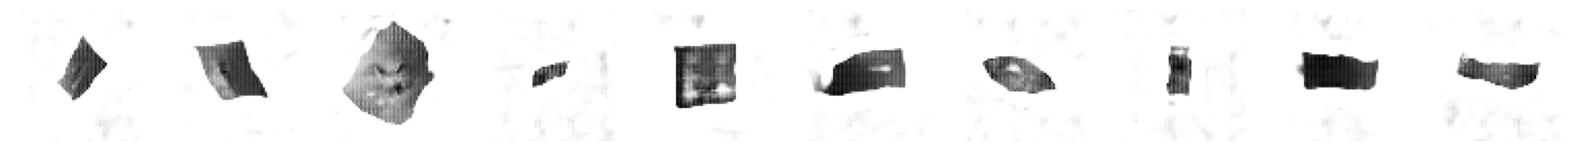

313/313 [==============================] - 73s 230ms/step - d_loss: -0.6767 - d_real_acc: 0.9892 - d_fake_acc: 0.9900 - d_acc: 0.9896 - g_loss: 14.3924 - g_acc: 0.0100
Epoch 92/100
313/313 [==============================] - 72s 224ms/step - d_loss: -0.5684 - d_real_acc: 0.9768 - d_fake_acc: 0.9774 - d_acc: 0.9771 - g_loss: 13.8138 - g_acc: 0.0226
Epoch 93/100
313/313 [==============================] - 75s 231ms/step - d_loss: -0.5037 - d_real_acc: 0.9732 - d_fake_acc: 0.9730 - d_acc: 0.9732 - g_loss: 12.6906 - g_acc: 0.0269
Epoch 94/100
313/313 [==============================] - 75s 235ms/step - d_loss: -0.3626 - d_real_acc: 0.9578 - d_fake_acc: 0.9589 - d_acc: 0.9584 - g_loss: 11.9855 - g_acc: 0.0410
Epoch 95/100
313/313 [==============================] - 74s 233ms/step - d_loss: -0.7670 - d_real_acc: 0.9998 - d_fake_acc: 0.9998 - d_acc: 0.9998 - g_loss: 15.3927 - g_acc: 2.2500e-04
Epoch 96/100
313/313 [==============================] - 74s 229ms/step - d_loss: -0.7677 - d_real_acc: 1

In [16]:
dcgan.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [17]:
# 최종 모델 저장
generator.save("./models/generator")
discriminator.save("./models/discriminator")

## 3. 새로운 이미지 생성 <a name="decode"></a>

In [18]:
# 표준 정규 분포에서 잠재 공간의 일부 포인트를 샘플링합니다.
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [19]:
# 샘플링된 포인트 디코딩
reconstructions = generator.predict(z_sample)

1/1 [==============================] - 0s 279ms/step


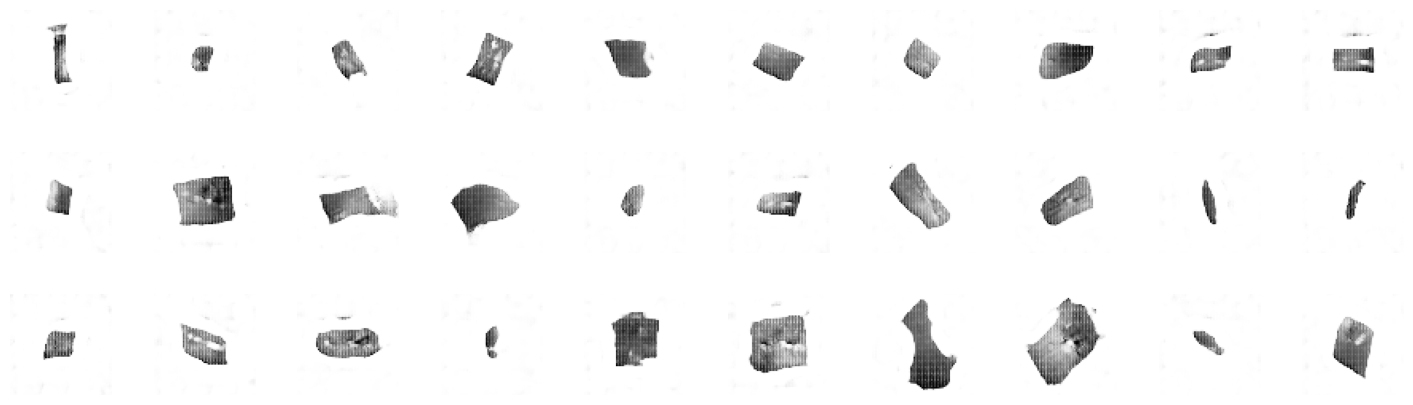

In [20]:
# 디코딩된 이미지 그리기
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# 얼굴 그리드 출력
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [21]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [22]:
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

1/1 [==============================] - 0s 97ms/step


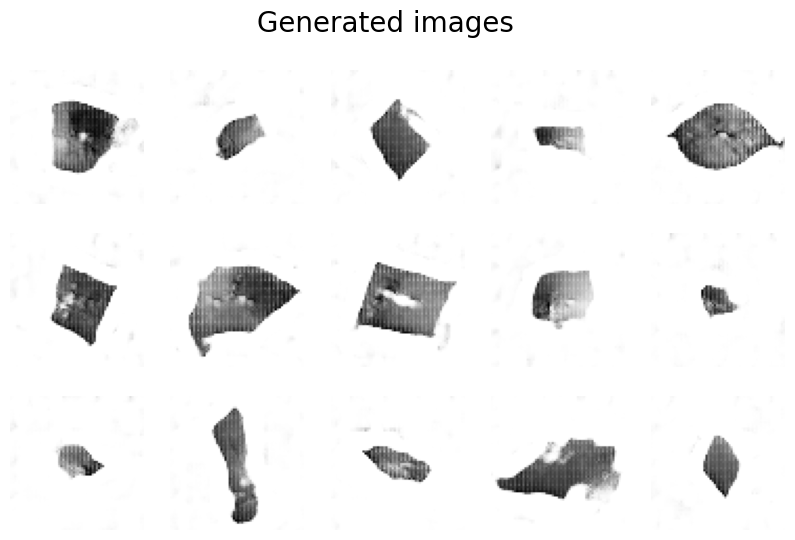

In [23]:
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

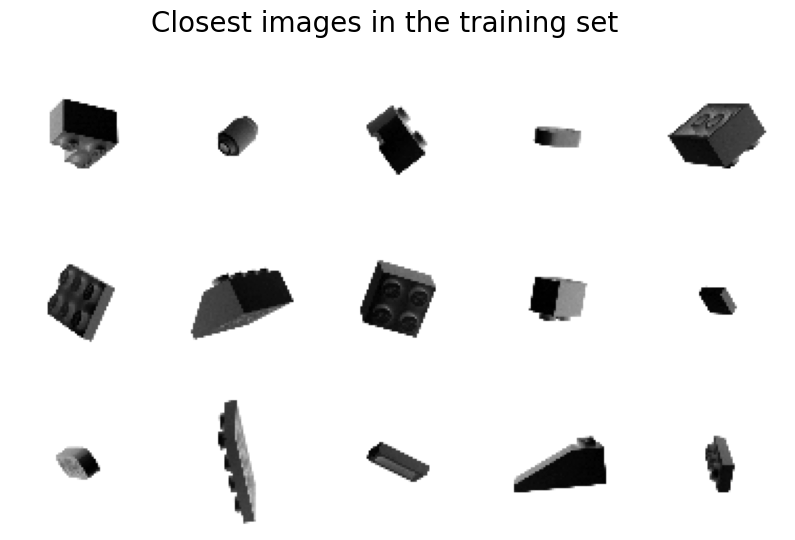

In [24]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()